In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
import itertools
import warnings
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pickle

In [114]:
data = pd.read_csv('data_daily.csv')
data = data.rename(columns={'# Date': 'Date'})
data.head()

,Date,Receipt_Count
0,2021-01-01,7564766
1,2021-01-02,7455524
2,2021-01-03,7095414
3,2021-01-04,7666163
4,2021-01-05,7771289


### Data Visualization

(Date             0
 Receipt_Count    0
 dtype: int64,
    Month  Receipt_Count
 0      1      236736687
 1      2      220033460
 2      3      248608625
 3      4      250644830
 4      5      263151748)

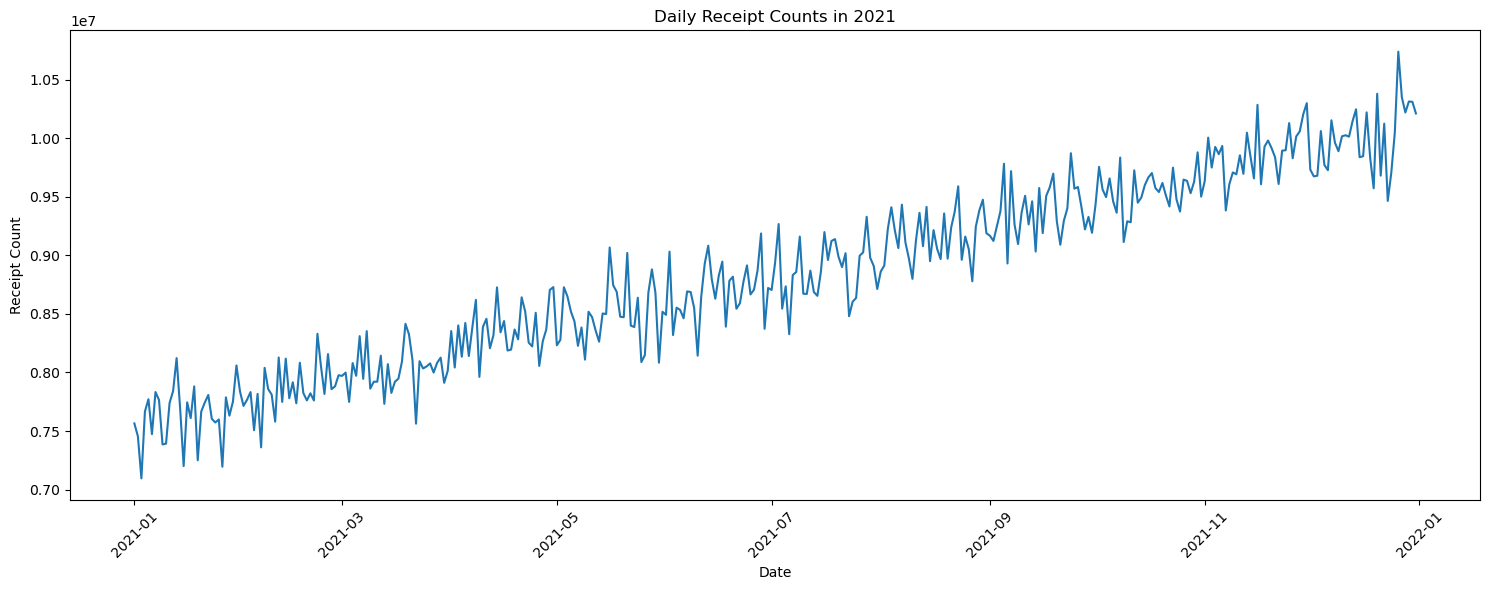

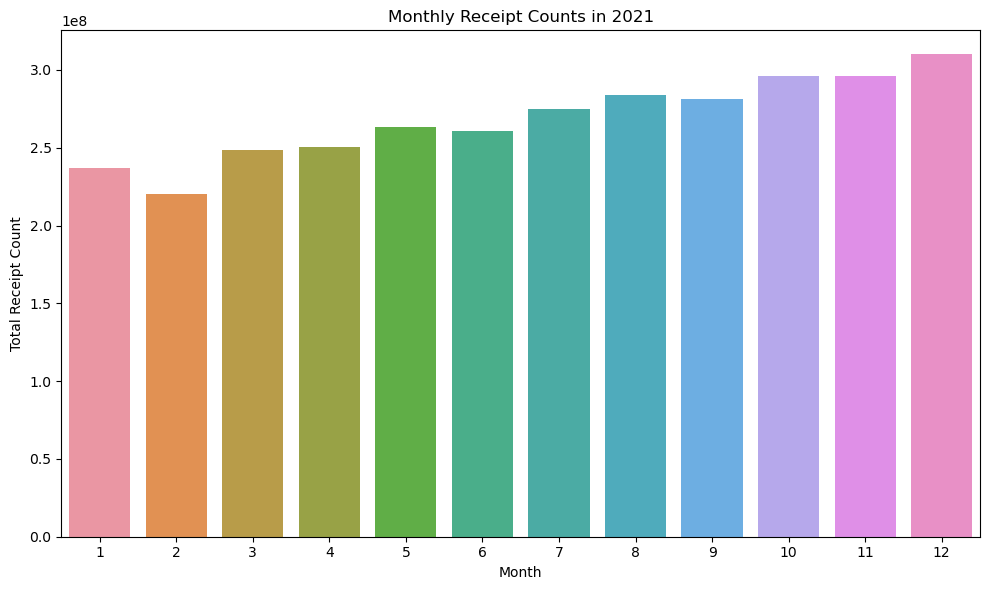

In [115]:
# Converting 'Date' to datetime format
data['Date'] = pd.to_datetime(data['Date'])

missing_values = data.isnull().sum()

data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['DayOfWeek'] = data['Date'].dt.dayofweek

# Plotting the receipt counts over time
plt.figure(figsize=(15, 6))
sns.lineplot(x=data['Date'], y=data['Receipt_Count'])
plt.title('Daily Receipt Counts in 2021')
plt.xlabel('Date')
plt.ylabel('Receipt Count')
plt.xticks(rotation=45)
plt.tight_layout()

# Summarizing receipt counts by month
monthly_receipts = data.groupby('Month')['Receipt_Count'].sum().reset_index()

# Plotting monthly receipt counts
plt.figure(figsize=(10, 6))
sns.barplot(x=monthly_receipts['Month'], y=monthly_receipts['Receipt_Count'])
plt.title('Monthly Receipt Counts in 2021')
plt.xlabel('Month')
plt.ylabel('Total Receipt Count')
plt.tight_layout()

missing_values, monthly_receipts.head()

### Stationary and Seasonlity Check
Based on the structure of data, I decide to choose SARIMA model because it can address seasonality and trends. The analysis below help us identify the parameters.

p, d, and q are the AR order, degree of differencing, and MA order for the non-seasonal part of the series.

P, D, Q are the same but for the seasonal part of the series.

s is the seasonality period.

The "Partial Autocorrelation" plot helps identify the order of the AR part. Significant spikes at initial lags indicate the number of AR terms. If there are spikes at seasonal lags, this indicates the number of seasonal AR terms. If the PACF cuts off after a certain lag (p), that’s an indication for the AR part. If the ACF cuts off after a certain lag (q), that’s an indication for the MA part.

The "Autocorrelation" plot helps identify the order of the MA part. Significant spikes at initial lags indicate the number of MA terms. If there are spikes at seasonal lags, this indicates the number of seasonal MA terms. Spikes in the PACF at seasonal lags suggest a need for seasonal AR terms (P). Spikes in the ACF at seasonal lags suggest a need for seasonal MA terms (Q).

{'ADF Statistic': 0.175044165720054, 'p-value': 0.9708266454651424}

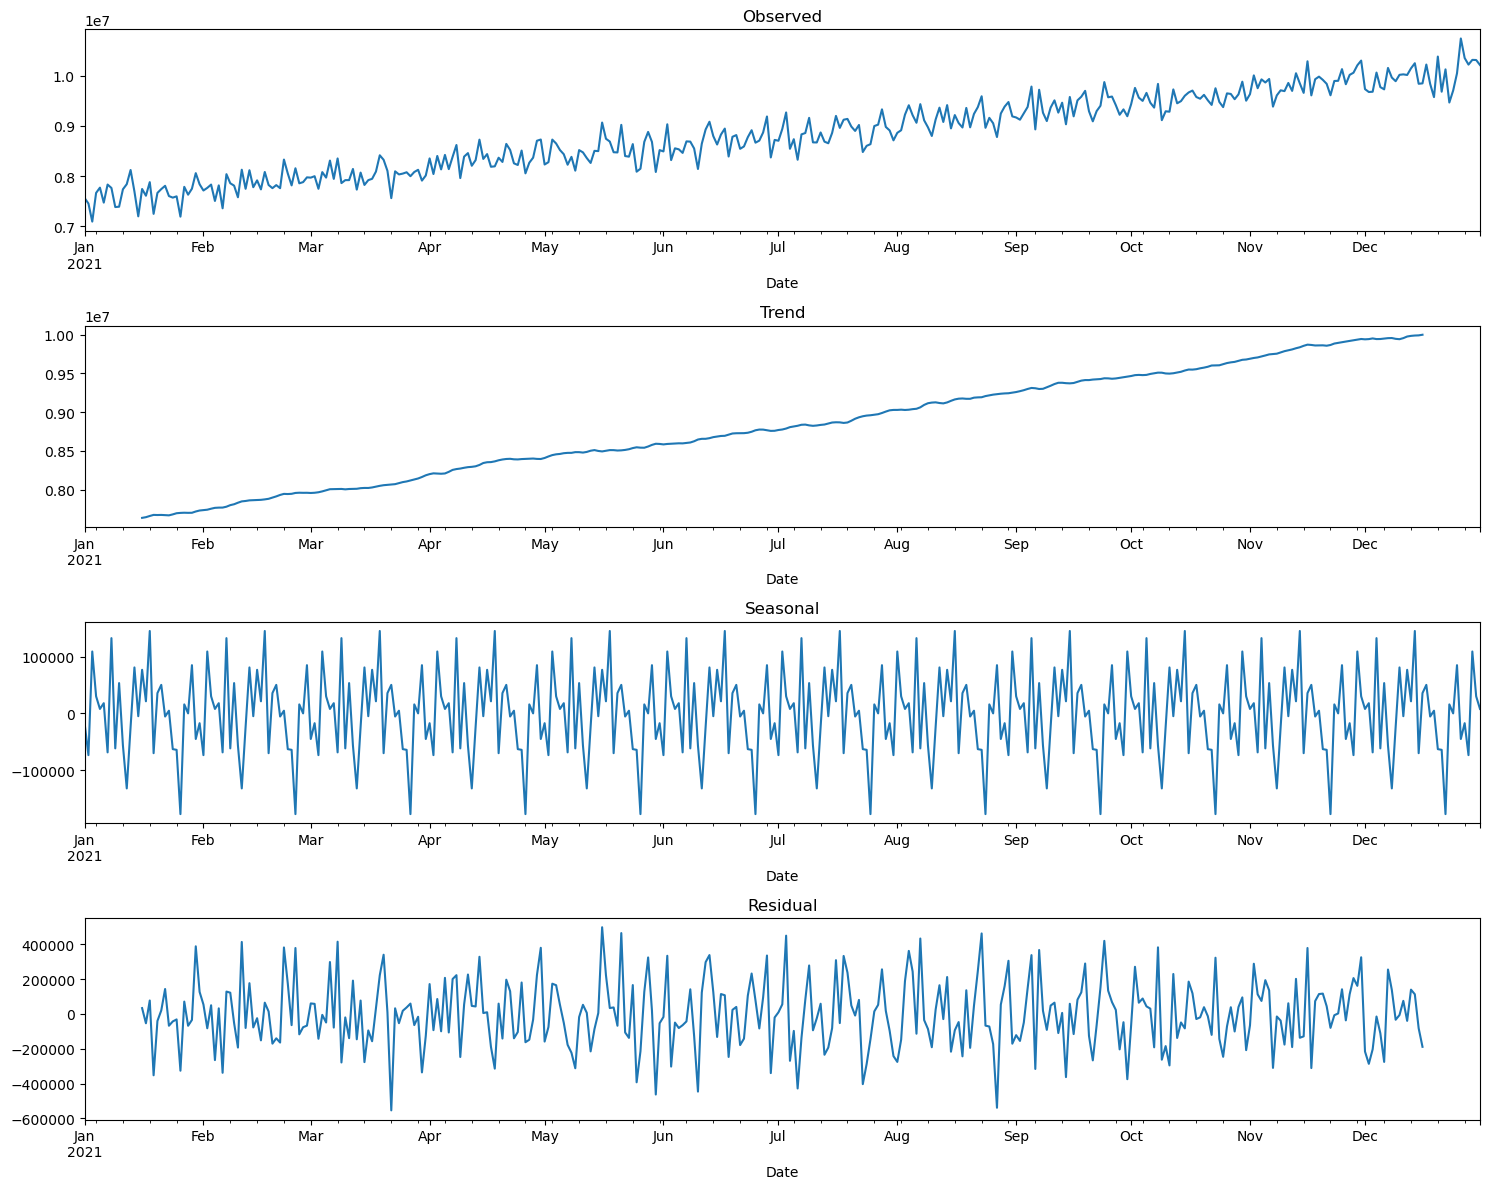

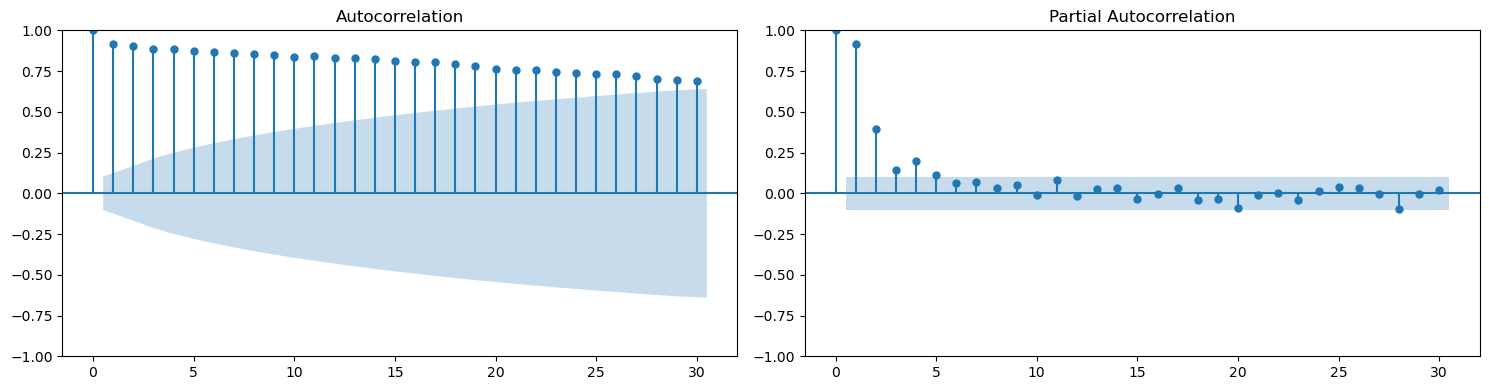

In [116]:
# Stationarity Check: Augmented Dickey-Fuller Test
adf_test = adfuller(data['Receipt_Count'])

# Seasonality Check: Seasonal Decomposition
decomposition = seasonal_decompose(data.set_index('Date')['Receipt_Count'], model='additive', period=30)

# Plotting Seasonal Decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))
decomposition.observed.plot(ax=ax1)
ax1.set_title('Observed')
decomposition.trend.plot(ax=ax2)
ax2.set_title('Trend')
decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Seasonal')
decomposition.resid.plot(ax=ax4)
ax4.set_title('Residual')
plt.tight_layout()

# Autocorrelation and Partial Autocorrelation Analysis
fig, (ax5, ax6) = plt.subplots(1, 2, figsize=(15, 4))
plot_acf(data['Receipt_Count'], ax=ax5, lags=30)
plot_pacf(data['Receipt_Count'], ax=ax6, lags=30, method='ywm')
plt.tight_layout()

adf_test_result = {'ADF Statistic': adf_test[0], 'p-value': adf_test[1]}

adf_test_result


Since the p-value from the above analysis is too large, we need to apply first order differencing to address non-stationary issue.
The autocorrelation is not clear yet, but partical autocorrelation tells us that p q is mostly between 1 and 3

### First Order Differencing:

{'ADF Statistic': -8.889819175651194, 'p-value': 1.2512872154223906e-14}

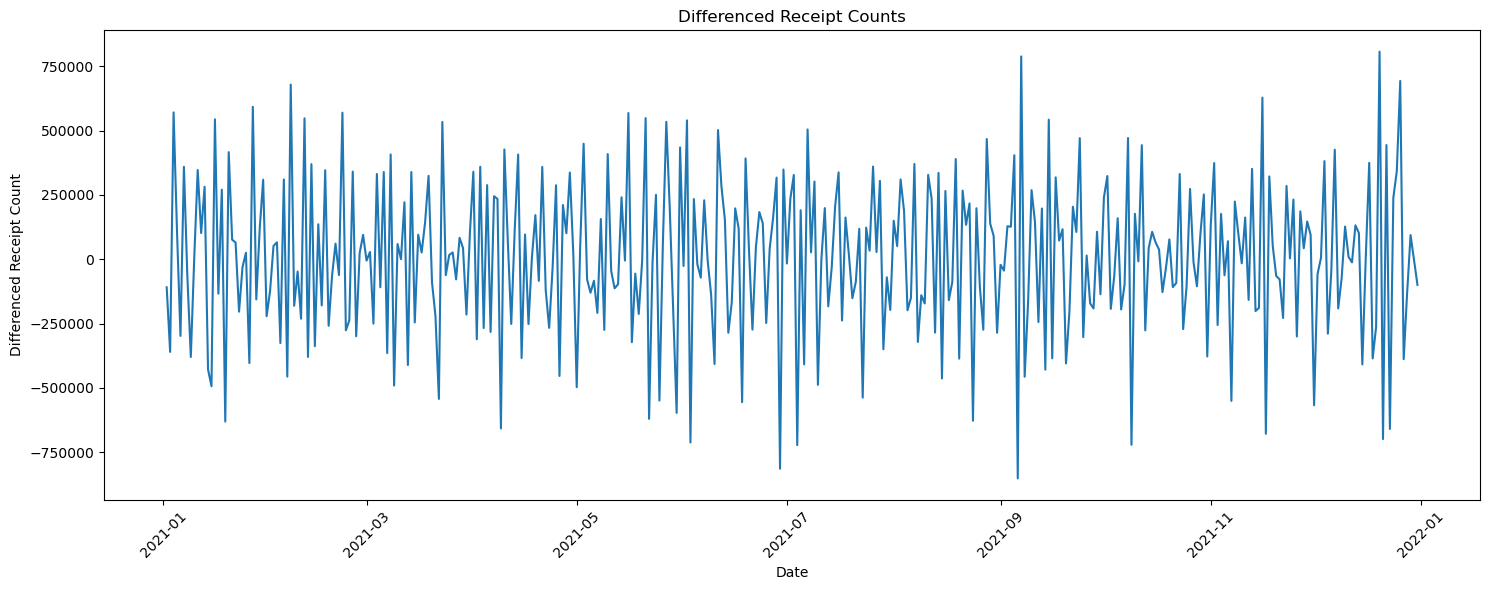

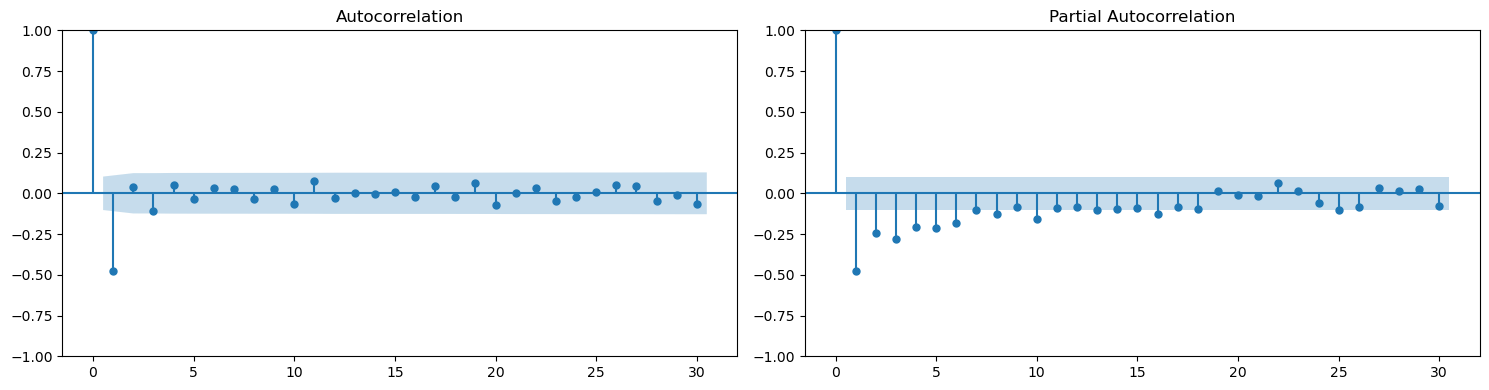

In [117]:
# First order Differencing the data to make it stationary
data['Receipt_Count_Diff'] = data['Receipt_Count'].diff().dropna()

# Checking stationarity again after differencing
adf_test_diff = adfuller(data['Receipt_Count_Diff'].dropna())

# Plotting the differenced data
plt.figure(figsize=(15, 6))
plt.plot(data['Date'], data['Receipt_Count_Diff'])
plt.title('Differenced Receipt Counts')
plt.xlabel('Date')
plt.ylabel('Differenced Receipt Count')
plt.xticks(rotation=45)
plt.tight_layout()

# Autocorrelation and Partial Autocorrelation Analysis on differenced data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
plot_acf(data['Receipt_Count_Diff'].dropna(), ax=ax1, lags=30)
plot_pacf(data['Receipt_Count_Diff'].dropna(), ax=ax2, lags=30, method='ywm')
plt.tight_layout()

adf_test_diff_result = {'ADF Statistic': adf_test_diff[0], 'p-value': adf_test_diff[1]}

adf_test_diff_result


The p-value is small enough. Therefore, first order differencing is sufficient. Thus, we can determine the d and D parameters in SARIMA model to be 1.
P and Q are mostly between 1 and 2.

## Model Training

In [109]:
# Define the parameter range based on the previous analysis results.
p = q = range(1, 4)  
P = Q = range(1, 3)
d = D = 1  
# If the data represents some daily measurement and there is a monthly pattern, considering that some months have 30 days
s = 30  

# Generate all different combinations of p, q
pdq = [(x[0], d, x[1]) for x in itertools.product(p, q)]
seasonal_pdq = [(x[0], D, x[1], s) for x in itertools.product(P, Q)]

best_aic = float("inf")
best_params = None

warnings.filterwarnings("ignore")

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(data['Receipt_Count'],
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

            results = mod.fit()

            # Compare and save the model if it has better AIC
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = (param, param_seasonal)

        except Exception as e:
            print(f"Model failed to fit for parameters {param}, {param_seasonal}: {e}")
            continue

print(f"Best SARIMA parameters: {best_params} with AIC: {best_aic}")

Best SARIMA parameters: ((2, 1, 3), (2, 1, 2, 30)) with AIC: 7543.350247579743


In [111]:
# Using the best SARIMA Parameters
p = 2  
d = 1  
q = 3 

P = 2 
D = 1 
Q = 2  
s = 30 

# Building the SARIMA Model
sarima_model = SARIMAX(data['Receipt_Count'], 
                       order=(p, d, q), 
                       seasonal_order=(P, D, Q, s),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

# Fitting the model
sarima_result = sarima_model.fit(disp=False)

sarima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                           Receipt_Count   No. Observations:                  365
Model:             SARIMAX(2, 1, 3)x(2, 1, [1, 2], 30)   Log Likelihood               -3761.675
Date:                                 Wed, 22 Nov 2023   AIC                           7543.350
Time:                                         21:51:36   BIC                           7579.334
Sample:                                              0   HQIC                          7557.800
                                                 - 365                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5720      1.332     -0.429      0.668      -3.183       2.039
ar.L2         -0.3655      0.794     -0.460      0.645      -1.922       1.191
ma.L1         -0.4081      1.411     -0.289      0.772      -3.173       2.357
ma.L2         -0.3260      1.256     -0.260      0.795      -2.787       2.135
ma.L3         -0.3586      0.858     -0.418      0.676      -2.040       1.323
ar.S.L30      -0.5596      0.366     -1.529      0.126      -1.277       0.158
ar.S.L60      -0.1918      0.214     -0.898      0.369      -0.610       0.227
ma.S.L30      -0.1689      0.365     -0.463      0.643      -0.883       0.546
ma.S.L60       0.0666      0.118      0.562      0.574      -0.166       0.299
sigma2       1.05e+11   1.52e-10   6.92e+20      0.000    1.05e+11    1.05e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                 0.32
Prob(Q):                              0.61   Prob(JB):                         0.85
Heteroskedasticity (H):               1.02   Skew:                            -0.04
Prob(H) (two-sided):                  0.91   Kurtosis:                         2.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.12e+36. Standard errors may be unstable.
"""

## Forecasting

In [118]:
# Forecasting for 2022 using the SARIMA model
forecast_days = 365 

# Generating the forecast
forecast = sarima_result.get_forecast(steps=forecast_days)
forecast_index = pd.date_range(start=data['Date'].iloc[-1] + pd.Timedelta(days=1), periods=forecast_days, freq='D')
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Creating a DataFrame for the forecast
forecast_df = pd.DataFrame({'Date': forecast_index, 'Forecast': forecast_values})
forecast_df['Lower_CI'] = forecast_conf_int.iloc[:, 0]
forecast_df['Upper_CI'] = forecast_conf_int.iloc[:, 1]

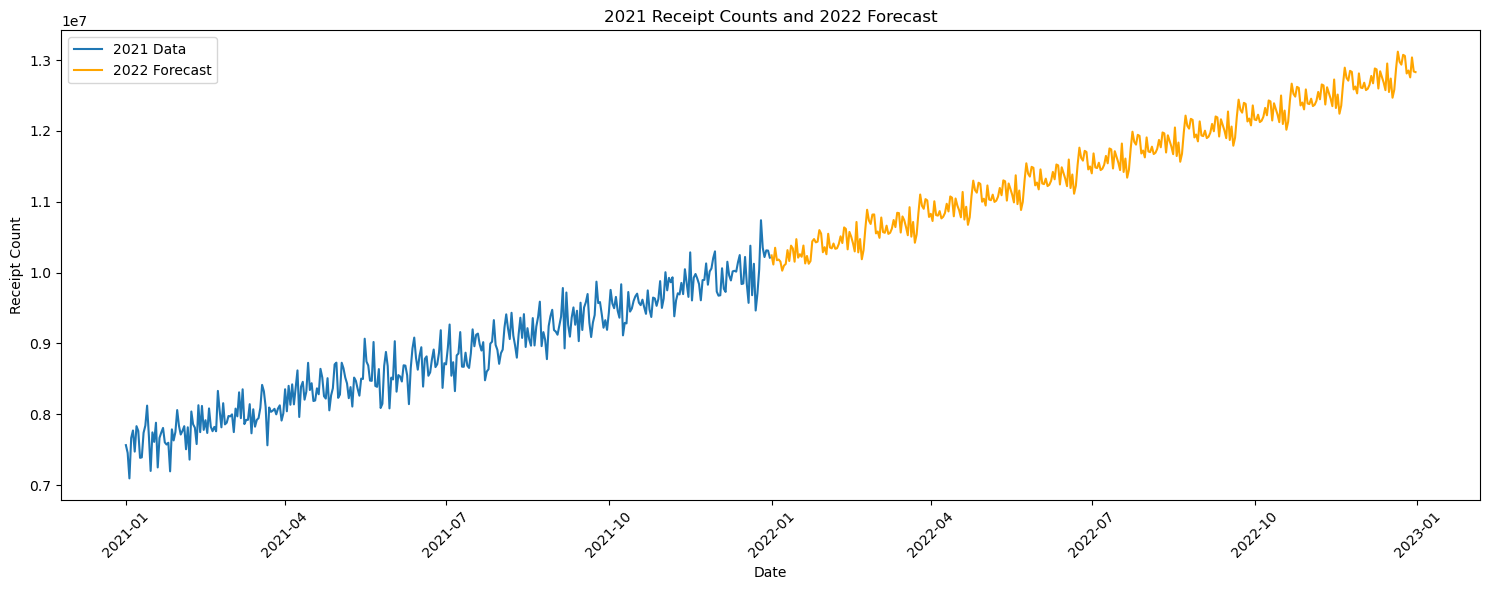

In [119]:
# Plotting the 2021 data with the 2022 forecast
plt.figure(figsize=(15, 6))
plt.plot(data['Date'], data['Receipt_Count'], label='2021 Data')
plt.plot(forecast_df['Date'], forecast_df['Forecast'], label='2022 Forecast', color='orange')
plt.title('2021 Receipt Counts and 2022 Forecast')
plt.xlabel('Date')
plt.ylabel('Receipt Count')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

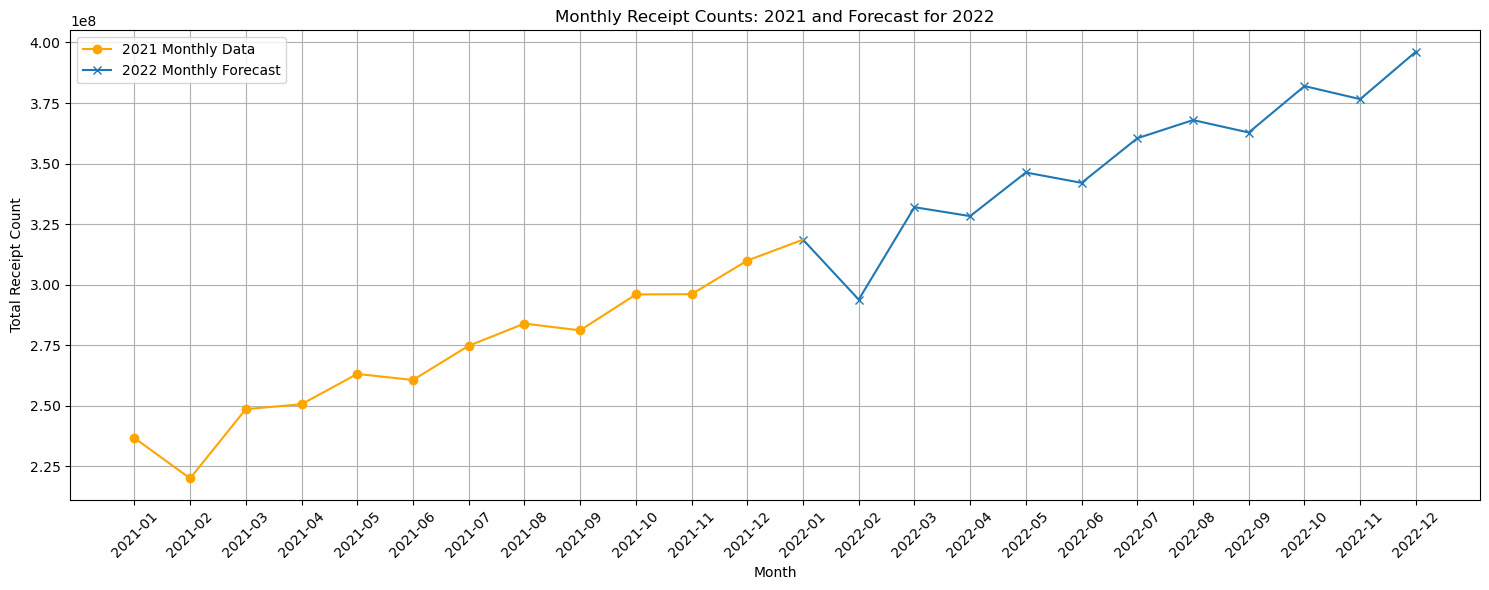

In [120]:
# Monthly plot
data['Date'] = pd.to_datetime(data['Date'])
monthly_data_2021 = data.groupby(data['Date'].dt.to_period('M')).sum().to_timestamp()
monthly_data_2021.index = monthly_data_2021.index.to_series().dt.strftime('%Y-%m')

forecast_df['Date'] = pd.to_datetime(forecast_df['Date'])
monthly_forecast_2022 = forecast_df.groupby(forecast_df['Date'].dt.to_period('M')).sum().to_timestamp()
monthly_forecast_2022.index = monthly_forecast_2022.index.to_series().dt.strftime('%Y-%m')

plt.figure(figsize=(15, 6))

# Plot 2021 data
plt.plot(monthly_data_2021.index, monthly_data_2021['Receipt_Count'], label='2021 Monthly Data', marker='o', linestyle='-', color='orange')

# Plot 2022 forecast
plt.plot(monthly_forecast_2022.index, monthly_forecast_2022['Forecast'], label='2022 Monthly Forecast', marker='x', linestyle='-')

plt.plot([monthly_data_2021.index[-1], monthly_forecast_2022.index[0]], 
         [monthly_data_2021['Receipt_Count'][-1], monthly_forecast_2022['Forecast'][0]], 
         marker='', linestyle='-', color='orange')

plt.title('Monthly Receipt Counts: 2021 and Forecast for 2022')
plt.xlabel('Month')
plt.ylabel('Total Receipt Count')
plt.legend()
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [121]:
# Save the model to a file
with open('sarima_result.pkl', 'wb') as file:
    pickle.dump(sarima_result, file)